# **Otimização de portfólio de produtos têxteis: uma aplicação de ciência de dados no segmento de malhas sintéticas**


In [22]:
import pandas as pd

df = pd.read_excel("produtos.xlsx")

cols_km = [
    "Segmento",
    "Tecnologias",
    "Superfície",
    "Fibra Predominante",
    "Largura (m)",
    "Gramatura (g/m²)",
    "Rend. Linear",
    "Rend. Metro"
]

df = df[cols_km]


In [23]:
num_cols = [
    "Largura (m)",
    "Gramatura (g/m²)",
    "Rend. Linear",
    "Rend. Metro"
]

cat_cols = [
    "Segmento",
    "Superfície",
    "Tecnologias",
    "Fibra Predominante"
]

df[num_cols] = df[num_cols].fillna("nao_informado")
df[cat_cols] = df[cat_cols].fillna("nao_informado")

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

df["Tecnologias"] = (
    df["Tecnologias"]
    .fillna("nenhuma")
    .astype(str)
    .str.lower()
    .str.strip()
)

df["Tecnologias"] = df["Tecnologias"].str.split(",")

df["Tecnologias"] = df["Tecnologias"].apply(
    lambda x: [t.strip() for t in x]
)

mlb = MultiLabelBinarizer()

tec_encoded = pd.DataFrame(
    mlb.fit_transform(df["Tecnologias"]),
    columns=[f"tec_{t}" for t in mlb.classes_],
    index=df.index
)

df = df.drop(columns=["Tecnologias"])
df = pd.concat([df, tec_encoded], axis=1)

In [25]:
num_cols = [
    "Largura (m)",
    "Gramatura (g/m²)",
    "Rend. Linear",
    "Rend. Metro"
]

for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

for col in num_cols:
    p5 = df[col].quantile(0.05)
    p95 = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=p5, upper=p95)

df[num_cols].dtypes

,0
Largura (m),float64
Gramatura (g/m²),float64
Rend. Linear,float64
Rend. Metro,float64


In [26]:
import unicodedata
import re

def clean_text(value):
    value = str(value).lower().strip()
    value = unicodedata.normalize("NFKD", value)
    value = value.encode("ascii", "ignore").decode("utf-8")
    value = re.sub(r"\s+", " ", value)
    return value

cat_cols = [col for col in cat_cols if col in df.columns]

for col in cat_cols:
    df[col] = df[col].apply(clean_text)

map_fibra = {
    "poliamida": "poliamida",
    "pa": "poliamida",
    "poliester": "poliester",
    "pes": "poliester",
    "elastano": "elastano",
    "el": "elastano"
}

df["Fibra Predominante"] = df["Fibra Predominante"].replace(map_fibra)

In [27]:
df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)

df_encoded.dtypes

,0
Largura (m),float64
Gramatura (g/m²),float64
Rend. Linear,float64
Rend. Metro,float64
tec_-,int64
tec_biodegradável,int64
tec_by dye,int64
tec_chlomax,int64
tec_compressão,int64
tec_defense,int64


In [28]:
from sklearn.preprocessing import StandardScaler

X = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)

In [29]:
X_scaled.describe().loc[["mean", "std"]]

,Largura (m),Gramatura (g/m²),Rend. Linear,Rend. Metro,tec_-,tec_biodegradável,tec_by dye,tec_chlomax,tec_compressão,tec_defense,...,Superfície_melange,Superfície_mescla,Superfície_piquet,Superfície_ribana,Superfície_tela vazada,Superfície_textura geometrico,Superfície_textura listra,Superfície_textura organica,Superfície_textura quadriculada,Fibra Predominante_poliester
mean,-2.224178e-15,0.000000,5.896311e-16,-2.313742e-16,7.463684e-17,4.664803e-18,-5.970947e-17,-5.597763e-17,-2.612289e-17,5.224579e-17,...,-5.970947e-17,7.183796e-17,0.000000,0.000000,-5.970947e-17,4.478211e-17,-1.492737e-17,0.000000,4.851395e-17,3.731842e-17
std,1.002107e+00,1.002107,1.002107e+00,1.002107e+00,1.002107e+00,1.002107e+00,1.002107e+00,1.002107e+00,1.002107e+00,1.002107e+00,...,1.002107e+00,1.002107e+00,1.002107,1.002107,1.002107e+00,1.002107e+00,1.002107e+00,1.002107,1.002107e+00,1.002107e+00


In [30]:
threshold = 0.01
n_rows = len(df_encoded)

In [31]:
rare_cols = []

for col in df_encoded.columns:
    if df_encoded[col].dropna().isin([0, 1]).all():
        freq = df_encoded[col].mean()
        if freq < threshold:
            rare_cols.append(col)

len(rare_cols)

12

In [32]:
df_reduced = df_encoded.drop(columns=rare_cols)

In [33]:
from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

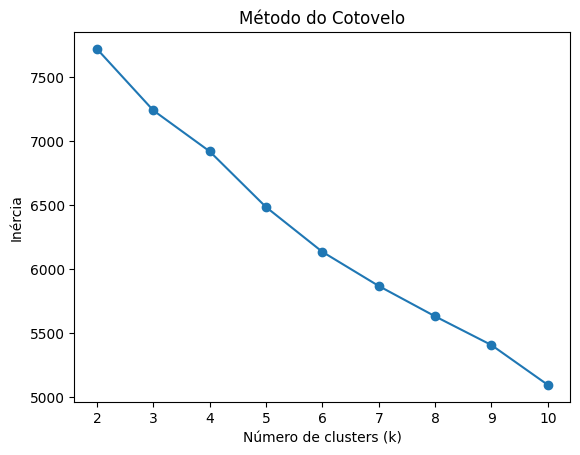

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.show()

In [35]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

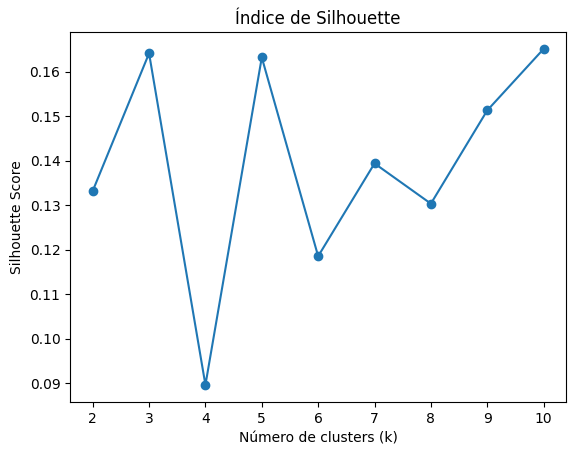

In [36]:
plt.figure()
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Índice de Silhouette")
plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reduced)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=df_reduced.columns,
    index=df_reduced.index
)

In [38]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    n_init=20,
    random_state=42
)

labels = kmeans.fit_predict(X_scaled)

In [39]:
centroids_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=df_reduced.columns
)

centroids_original["cluster"] = range(kmeans.n_clusters)
centroids_original

,Largura (m),Gramatura (g/m²),Rend. Linear,Rend. Metro,tec_-,tec_defense,tec_dope dye,tec_eco,tec_four way,tec_hidro,...,Superfície_liso,Superfície_maquinetado,Superfície_piquet,Superfície_ribana,Superfície_textura geometrico,Superfície_textura listra,Superfície_textura organica,Superfície_textura quadriculada,Fibra Predominante_poliester,cluster
0,1.689824,147.955882,4.093725,6.925990,-3.330669e-16,0.098039,2.775558e-17,9.215686e-01,2.775558e-17,0.019608,...,0.156863,-6.938894e-18,9.803922e-02,3.921569e-02,0.392157,-3.469447e-17,3.921569e-02,5.882353e-02,1.000000e+00,0
1,1.542468,267.467532,2.501558,3.805455,7.532468e-01,0.051948,0.000000e+00,2.597403e-02,5.194805e-02,0.012987,...,0.597403,1.387779e-17,3.896104e-02,5.194805e-02,0.090909,9.090909e-02,9.090909e-02,4.857226e-17,4.155844e-01,1
2,1.650000,247.000000,2.617400,4.282000,0.000000e+00,0.000000,1.000000e+00,2.775558e-17,2.000000e-01,0.000000,...,1.000000,0.000000e+00,-6.938894e-18,0.000000e+00,0.000000,0.000000e+00,-6.938894e-18,0.000000e+00,-1.110223e-16,2
3,1.642798,142.991071,4.346190,7.114839,8.333333e-01,0.107143,-3.469447e-18,2.380952e-02,-3.469447e-18,0.011905,...,0.452381,2.081668e-17,2.380952e-02,2.380952e-02,0.285714,3.571429e-02,6.938894e-17,7.142857e-02,7.619048e-01,3
4,1.580952,193.095238,3.402238,5.366667,4.761905e-02,0.952381,0.000000e+00,9.523810e-02,0.000000e+00,0.000000,...,0.285714,1.904762e-01,9.523810e-02,6.938894e-18,0.142857,4.761905e-02,4.761905e-02,1.904762e-01,1.428571e-01,4


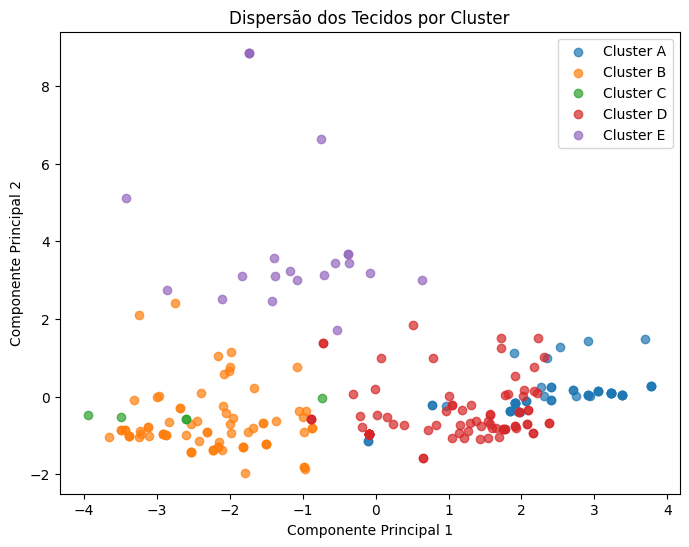

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
    index=X_scaled.index
)

df_pca["cluster"] = labels

cluster_names = {
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C",
    3: "Cluster D",
    4: "Cluster E"
}

plt.figure(figsize=(8,6))

for c in sorted(df_pca["cluster"].unique()):
    subset = df_pca[df_pca["cluster"] == c]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=cluster_names.get(c, f"Cluster {c}"),
        alpha=0.7
    )

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Dispersão dos Tecidos por Cluster")
plt.legend()
plt.grid(False)
plt.show()
